# Training the higher resolution



In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from fastai.conv_learner import *
from fastai.dataset import *
from fastai.sgdr import SaveBestModel

import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

Setting CUDA devices...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
TMP_NAME = 'trainGPU0'
DATASET_ROOT = '/media/data-nvme/dev/datasets/airbus/'
PATH = DATASET_ROOT
TRAIN = DATASET_ROOT + 'train_v2/'
TEST = DATASET_ROOT + 'test_v2/'
SEGMENTATION = DATASET_ROOT + 'train_ship_segmentations_v2.csv'
PRETRAINED = DATASET_ROOT + 'models/resnet34s256_kaggle-airbus-l0.053-a0.981.h5'
DETECTION_TEST_PRED = DATASET_ROOT + 'models/ship_detection.csv'
!rm -r {PATH}{TMP_NAME} # Cleaning temp directory
BEST_MODEL = 'Unet34_s768i2_kaggle-airbus5-3-570'

rm: cannot remove '/media/data-nvme/dev/datasets/airbus/trainGPU0': No such file or directory


In [4]:
exclude_list = ['6384c3e78.jpg'] #corrupted image

In [5]:
nw = 12   #number of workers for data loader
arch = resnet34 #specify target architecture

In [6]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)
segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')

In [7]:
def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n = cut_empty(tr_n)
val_n = cut_empty(val_n)

In [8]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [9]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        mask = np.zeros((768,768), dtype=np.uint8) if (self.path == TEST) \
            else get_mask(self.fnames[i], self.segmentation_df)
        img = Image.fromarray(mask).resize((self.sz, self.sz)).convert('RGB')
        return np.array(img).astype(np.float32)
    
    def get_c(self): return 0

In [10]:
class RandomLighting(Transform):
    def __init__(self, b, c, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.b,self.c = b,c

    def set_state(self):
        self.store.b_rand = rand0(self.b)
        self.store.c_rand = rand0(self.c)

    def do_transform(self, x, is_y):
        if is_y and self.tfm_y != TfmType.PIXEL: return x  #add this line to fix the bug
        b = self.store.b_rand
        c = self.store.c_rand
        c = -1/(c-1) if c<0 else c+1
        x = lighting(x, b, c)
        return x

In [11]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.CLASS),
                RandomDihedral(tfm_y=TfmType.CLASS),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, 
                aug_tfms=aug_tfms)
    tr_names = tr_n if (len(tr_n)%bs == 0) else tr_n[:-(len(tr_n)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
#     md.is_multi = False
    return md

In [12]:
cut,lr_cut = model_meta[arch]

In [13]:
def get_base():                   #load ResNet34 model
    layers = cut_model(arch(True), cut)
    return nn.Sequential(*layers)

def load_pretrained(model, path): #load a model pretrained on ship/no-ship classification
    weights = torch.load(path, map_location=lambda storage, loc: storage)
    model.load_state_dict(weights, strict=False)
            
    return model

In [14]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [15]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [17]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [18]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [19]:
def save_when_acc(self, metrics):
    filename = "{}-{}-{}".format(self.name, self.epoch, random.randint(1,1000))
    print(filename)
    self.model.save(f'{filename}')

SaveBestModel.save_when_acc = save_when_acc

In [20]:
m_base = load_pretrained(get_base(),PRETRAINED)
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

epochs: 8 cycle_len: 1 use_clr: (40, 10) SZ: 768 BS: 6 LR: [0.00001 0.0001  0.001  ] wd: 1e-07 from_model: Unet34_s768i2_kaggle-airbus5-3-570


Unet34_s768i1_kaggle-airbus5-1-265                                 
epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    0      0.212975   0.187275   0.99886    0.871518   0.777727  
Unet34_s768i1_kaggle-airbus5-3-610                                 
    1      0.203502   0.188064   0.998869   0.871248   0.77799   
Unet34_s768i1_kaggle-airbus5-5-662                                 
    2      0.195564   0.182257   0.99888    0.874542   0.781902  
Unet34_s768i1_kaggle-airbus5-7-171                               
    3      0.184335   0.181102   0.998881   0.875304   0.782885  
Unet34_s768i1_kaggle-airbus5-9-664                               
    4      0.196117   0.179334   0.998893   0.876495   0.784628  
Unet34_s768i1_kaggle-airbus5-11-719                                
    5      0.177482   0.177265   0.998911   0.877768   0.786674  
Unet34_s768i1_kaggle-airbus5-13-574                                
    6      0.1723     0.177253   0.998908   0.877706   0.786506  

[0.17653753760988633,
 0.9989169672985394,
 0.8779947206846227,
 0.7870484010734752]

---------- End of  1 ------------------------------
epochs: 1 cycle_len: 1 use_clr: (40, 10) SZ: 768 BS: 6 LR: [0.00001 0.0001  0.001  ] wd: 1e-07 from_model: Unet34_s768i2_kaggle-airbus5-3-570


 14%|█▍        | 938/6732 [27:35<2:50:28,  1.77s/it, loss=0.188]

KeyboardInterrupt: 

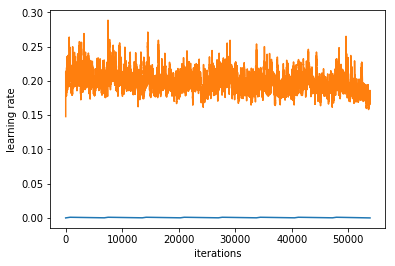

In [21]:
global_results = collections.OrderedDict([])
wd=1e-7
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])
training_loop = [
    [8, 1, (40,10), lrs/10, 1e-7],
    [1, 1, (40,10), lrs/10, 1e-7],
    [1, 1, (40,10), lrs/10, 1e-7],
    [2, 1, (30,10), lrs/15, 1e-7],
    [3, 1, (20,10), lrs/20, 1e-6],
    [4, 1, (40,8), lrs/30, 1e-5],
    [5, 1, (40,10), lrs/10, 1e-7]
]
sz = 768 #image size
bs = 6  #batch size
md = get_data(sz,bs)
learn = ConvLearner(md, models, tmp_name=TMP_NAME)
learn.opt_fn=optim.Adam
learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]
learn.load(BEST_MODEL)
i = 0
sz = 768 #image size
bs = 6  #batch size
md = get_data(sz,bs)
learn.set_data(md)
learn.unfreeze()
learn.bn_freeze(True)

for epochs, cycle_len, use_clr, learning_rate, wd in training_loop:
    i+=1
    #     epoch      trn_loss   val_loss   <lambda>   dice       IoU        
    #     Unet34_s384i3_kaggle-airbus4-7-148                             
    #     3      0.172256   0.16689    0.998878   0.88579    0.79573  
    print("epochs:",epochs,"cycle_len:",cycle_len,"use_clr:",use_clr,"SZ:", sz, "BS:", bs, "LR:", learning_rate, "wd:", wd, "from_model:", BEST_MODEL)
    learn.fit(learning_rate,epochs,wds=wd,cycle_len=cycle_len,use_clr=use_clr, best_save_name='Unet34_s' + str(sz)  + 'i' + str(i) + "_kaggle-airbus5")
    learn.sched.plot_lr()
    learn.sched.plot_loss()
    print("---------- End of ", i, "------------------------------")


